# Single Replica TIS

This notebook shows how to run single replica TIS move scheme. This assumes you can load engine, network, and initial sample from a previous calculation.

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from openpathsampling.visualize import PathTreeBuilder, PathTreeBuilder
from IPython.display import SVG, HTML

def ipynb_visualize(movevis):
    """Default settings to show a movevis in an ipynb."""
    view = movevis.renderer
    view.zoom = 1.5
    view.scale_y = 18
    view.scale_th = 20
    view.font_size = 0.4
    return view

Open the storage and load things from it.

In [3]:
#old_store = paths.AnalysisStorage("mstis.nc")
old_store = paths.Storage("mstis.nc")  # if not actually doing analysis, but loading network, etc

In [4]:
network = old_store.networks[0]
engine = old_store.engines[0]
template = old_store.snapshots[0]

In [5]:
network.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
network.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
#rate = network.rate_matrix(old_store.steps)

One of the points of SRTIS is that we use a bias (which comes from an estimate of the crossing probability) in order to improve our sampling.

In [6]:
# this is the normal way you'd get this table
#table = {}
#for t in network.sampling_transitions:
#    for ens, lambda_ens in zip(t.ensembles, [0.04, 0.09, 0.15]):
#        table[ens] = t.tcp(lambda_ens)
#for ens in network.special_ensembles['ms_outer'].keys():
#    table[ens] = 0.0
#    for t in network.sampling_transitions:
#        table[ens] += t.tcp(0.25)
#    table[ens] *= len(network.special_ensembles['ms_outer'].keys())
#    # TODO: Justify the math behind that. Also, run it a bunch more times.
    
# However, we usually have a short (bad statistics) run in "mstis.nc"
# Here are results that I got from a 10k MC step run
#desired_table = {
#    "Out A 0" : 1.0,
#    "Out A 1" : 0.13631671445062318,
#    "Out A 2" : 0.024940771341558789,
#    "Out B 0" : 1.0,
#    "Out B 1" : 0.17104343305339545,
#    "Out B 2" : 0.03927673242602249,
#    "Out C 0" : 1.0,
#    "Out C 1" : 0.19353622940592666,
#    "Out C 2" : 0.066440692846493191,
#    "[UnionEnsemble]" : (0.0030508557603910859+0.0087422825961122538+0.017858280680711457)*3
#} # Union is sum of outermost vals for all 3 versions, times the number of versions

# Here are results that I got from a 20k MC step run
desired_table = {
    "Out A 0" : 1.0,
    "Out A 1" : 0.13293104100673198,
    "Out A 2" : 0.044370838092911397,
    "Out B 0" : 1.0,
    "Out B 1" : 0.13846029208307947,
    "Out B 2" : 0.042622152070289694,
    "Out C 0" : 1.0,
    "Out C 1" : 0.19485705066078274,
    "Out C 2" : 0.053373003923696649,
    "[UnionEnsemble]" : (0.021975696374764188 + 0.021955804935886884 + 0.029175949467020165) / 3
} # Union is average of all 3 version, divided by the number of possible initial states (assuming equal prob)

dict_A = {
    "Out A 0" : 1.0,
    "Out A 1" : 0.13293104100673198,
    "Out A 2" : 0.044370838092911397,
    "[UnionEnsemble]" : 0.021975696374764188
}

dict_B = {
    "Out B 0" : 1.0,
    "Out B 1" : 0.13846029208307947,
    "Out B 2" : 0.042622152070289694,
    "[UnionEnsemble]" : 0.021955804935886884    
}

dict_C = {
    "Out C 0" : 1.0,
    "Out C 1" : 0.19485705066078274,
    "Out C 2" : 0.053373003923696649,
    "[UnionEnsemble]" : 0.029175949467020165    
}

# now we'll set `table` based on `desired_table`
table = {}
my_ensembles = network.sampling_ensembles + network.special_ensembles['ms_outer'].keys()
for ens in my_ensembles:
    table[ens] = desired_table[ens.name]

In [7]:
stateA = old_store.volumes['A']
stateB = old_store.volumes['B']
stateC = old_store.volumes['C']
enslist_A = network.transitions[(stateA, stateB)].ensembles + network.special_ensembles['ms_outer'].keys()
enslist_B = network.transitions[(stateB, stateA)].ensembles + network.special_ensembles['ms_outer'].keys()
enslist_C = network.transitions[(stateC, stateA)].ensembles + network.special_ensembles['ms_outer'].keys()
bias_A = paths.BiasEnsembleTable.ratios_from_dictionary({ens : dict_A[ens.name] for ens in enslist_A})
bias_B = paths.BiasEnsembleTable.ratios_from_dictionary({ens : dict_B[ens.name] for ens in enslist_B})
bias_C = paths.BiasEnsembleTable.ratios_from_dictionary({ens : dict_C[ens.name] for ens in enslist_C})

In [8]:
bias_A.df

,Out A 0,Out A 1,Out A 2,[UnionEnsemble]
Out A 0,1,7.5227,22.5373,45.5048
Out A 1,0.132931,1,2.99591,6.049
Out A 2,0.0443708,0.333788,1,2.01909
[UnionEnsemble],0.0219757,0.165317,0.495273,1


In [9]:
bias_B.df

,Out B 0,Out B 1,Out B 2,[UnionEnsemble]
Out B 0,1,7.22229,23.462,45.546
Out B 1,0.13846,1,3.24855,6.30632
Out B 2,0.0426222,0.307829,1,1.94127
[UnionEnsemble],0.0219558,0.158571,0.515127,1


In [10]:
bias_C.df

,Out C 0,Out C 1,Out C 2,[UnionEnsemble]
Out C 0,1,5.13197,18.7361,34.2748
Out C 1,0.194857,1,3.65085,6.67869
Out C 2,0.053373,0.273909,1,1.82935
[UnionEnsemble],0.0291759,0.14973,0.546642,1


In [11]:
bias = bias_A + bias_B + bias_C

In [12]:
bias.df

,Out A 0,Out A 1,Out A 2,Out B 0,Out B 1,Out B 2,Out C 0,Out C 1,Out C 2,[UnionEnsemble]
Out A 0,1,7.5227,22.5373,NaN,NaN,NaN,NaN,NaN,NaN,45.5048
Out A 1,0.132931,1,2.99591,NaN,NaN,NaN,NaN,NaN,NaN,6.049
Out A 2,0.0443708,0.333788,1,NaN,NaN,NaN,NaN,NaN,NaN,2.01909
Out B 0,NaN,NaN,NaN,1,7.22229,23.462,NaN,NaN,NaN,45.546
Out B 1,NaN,NaN,NaN,0.13846,1,3.24855,NaN,NaN,NaN,6.30632
Out B 2,NaN,NaN,NaN,0.0426222,0.307829,1,NaN,NaN,NaN,1.94127
Out C 0,NaN,NaN,NaN,NaN,NaN,NaN,1,5.13197,18.7361,34.2748
Out C 1,NaN,NaN,NaN,NaN,NaN,NaN,0.194857,1,3.65085,6.67869
Out C 2,NaN,NaN,NaN,NaN,NaN,NaN,0.053373,0.273909,1,1.82935
[UnionEnsemble],0.0219757,0.165317,0.495273,0.0219558,0.158571,0.515127,0.0291759,0.14973,0.546642,1


In [13]:
transAB = network.transitions.values()[4]
ensA0 = transAB.ensembles[0]
ensA1 = transAB.ensembles[1]
print bias.bias_probability(ensA1, ensA0)

0.194857050661


In [14]:
bias.dataframe.loc[2, 7]

nan

In [15]:
for state in network.states:
    print repr(state), repr(state.name)

<openpathsampling.volume.CVRangeVolume object at 0x10d85e9d0> u'A'
<openpathsampling.volume.CVRangeVolume object at 0x10d85ef50> u'B'
<openpathsampling.volume.CVRangeVolume object at 0x10d5ec8d0> u'C'


Here we actually set up the SRTIS move scheme for the given network. It only requires one line:

In [16]:
scheme = paths.SRTISScheme(network, bias=bias, engine=engine)

Now we'll visualize the SRTIS move scheme.

In [17]:
movevis = paths.visualize.MoveTreeBuilder()
#movevis.mover(scheme.move_decision_tree(), network.all_ensembles)
#SVG(ipynb_visualize(movevis).to_svg())

Next we need to set up an appropriate single-replica initial sample set. We'll take the last version of from one of the outer TIS ensembles.

In [18]:
final_samp0 = old_store.steps[len(old_store.steps)-1].active[network.sampling_ensembles[-1]]

In [19]:
sset = paths.SampleSet([final_samp0])

Finally, we set up the new storage file and the new simulation. 

In [20]:
storage = paths.Storage("srtis.nc", "w", template)

In [21]:
srtis = paths.PathSampling(
    storage=storage,
    globalstate=sset,
    move_scheme=scheme
)

In [22]:
n_steps_to_run = int(scheme.n_steps_for_trials(
        mover=scheme.movers['minus'][0], 
        n_attempts=1
    ))
print n_steps_to_run

1230


In [23]:
# logging creates ops_output.log file with details of what the calculation is doing
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [24]:
%%time
multiplier = 3
srtis.run_until(multiplier*n_steps_to_run)

Working on Monte Carlo cycle number 12300.
DONE! Completed 12300 Monte Carlo cycles.
CPU times: user 7min 4s, sys: 44.4 s, total: 7min 48s
Wall time: 7min 44s


In [25]:
storage.close()

From here, we'll be doing the analysis of the SRTIS run.

In [26]:
%%time
storage = paths.AnalysisStorage("srtis.nc")
scheme = storage.schemes[0]

CPU times: user 16.5 s, sys: 857 ms, total: 17.3 s
Wall time: 17.4 s


In [27]:
scheme.move_summary(storage.steps)

ms_outer_shooting ran 20.000% (expected 0.41%) of the cycles with acceptance 185/273 (67.77%)
repex ran 47.766% (expected 3.66%) of the cycles with acceptance 194/652 (29.75%)
shooting ran 15.751% (expected 3.66%) of the cycles with acceptance 140/215 (65.12%)
minus ran 0.000% (expected 0.24%) of the cycles with acceptance 0/0 (nan%)
pathreversal ran 16.484% (expected 2.03%) of the cycles with acceptance 173/225 (76.89%)


In [28]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover Out B 2 ran 0.806% (expected 0.41%) of the cycles with acceptance 4/11 (36.36%)
OneWayShootingMover Out A 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out B 1 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out B 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out A 1 ran 1.685% (expected 0.41%) of the cycles with acceptance 15/23 (65.22%)
OneWayShootingMover Out A 2 ran 5.055% (expected 0.41%) of the cycles with acceptance 40/69 (57.97%)
OneWayShootingMover Out C 1 ran 1.612% (expected 0.41%) of the cycles with acceptance 16/22 (72.73%)
OneWayShootingMover Out C 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out C 2 ran 6.593% (expected 0.41%) of the cycles with acceptance 65/90 (72.22%)


In [29]:
scheme.move_summary(storage.steps, 'minus')

SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)
SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)
SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)


In [30]:
scheme.move_summary(storage.steps, 'repex')

EnsembleHop Out B 1->Out B 2 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out C 1->Out C 0 ran 0.806% (expected 0.20%) of the cycles with acceptance 0/11 (0.00%)
EnsembleHop Out C 2->[UnionEnsemble] ran 3.004% (expected 0.20%) of the cycles with acceptance 37/41 (90.24%)
EnsembleHop Out C 0->Out C 1 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out B 1->Out B 0 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out A 0->Out A 1 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out C 1->Out C 2 ran 0.733% (expected 0.20%) of the cycles with acceptance 9/10 (90.00%)
EnsembleHop Out A 1->Out A 2 ran 0.659% (expected 0.20%) of the cycles with acceptance 9/9 (100.00%)
EnsembleHop Out B 2->Out B 1 ran 0.220% (expected 0.20%) of the cycles with acceptance 0/3 (0.00%)
EnsembleHop [UnionEnsemble]->Out C 2 ran 11.136% (expected 0.20%) of the cycles with acceptance 3

In [31]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 3.736% (expected 0.20%) of the cycles with acceptance 37/51 (72.55%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 7.473% (expected 0.20%) of the cycles with acceptance 102/102 (100.00%)
PathReversal ran 1.172% (expected 0.20%) of the cycles with acceptance 5/16 (31.25%)
PathReversal ran 0.440% (expected 0.20%) of the cycles with acceptance 0/6 (0.00%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 2.637% (expected 0.20%) of the cycles with acceptance 18/36 (50.00%)
PathReversal ran 1.026% (expected 0.20%) of the cycles with acceptance 11/14 (78.57%)


In [32]:
replica = storage.samplesets[0].samples[0].replica
ensemble_trace = paths.trace_ensembles_for_replica(replica, storage.steps)
print len(ensemble_trace)

12301


In [33]:
#repex_acceptance = {}
#for mover in scheme.movers['repex']:
#    acceptance = [scheme._mover_acceptance[key] for key in scheme._mover_acceptance if key[0] == mover]
#    repex_acceptance[mover] = acceptance[0]
#
#scheme.build_balance_partners()
#tagged_movers = []
#for mover in repex_acceptance:
#    if mover in tagged_movers:
#        break
#    name = mover.name
#    acceptance = repex_acceptance[mover]
#    acc = float(acceptance[0])/acceptance[1]
#    bp_acceptance = repex_acceptance[scheme.balance_partners[mover][0]]
#    bp_acc = float(bp_acceptance[0])/bp_acceptance[1]
#    in_name = mover.input_ensembles[0].name
#    out_name = mover.output_ensembles[0].name
#    if (desired_table[out_name] > desired_table[in_name]):
#        foo = in_name
#        in_name = out_name
#        out_name = foo
#        foo = acc
#        acc = bp_acc
#        bp_acc = foo
#        
#    out_over_in = desired_table[out_name] / desired_table[in_name]
#    in_over_out = desired_table[in_name] / desired_table[out_name]
#
#    if (in_name, out_name) not in tagged_movers:
#        print "{:.1%} {:.1%} {:.1%} {:s}".format(acc, bp_acc, out_over_in, in_name + "->" + out_name)
#    tagged_movers += [(in_name, out_name)]
    

In [34]:
srtis_ensembles = scheme.network.sampling_ensembles+scheme.network.special_ensembles['ms_outer'].keys()
srtis_ensemble_numbers = {e : srtis_ensembles.index(e) for e in srtis_ensembles}
# this next is just for pretty printing
srtis_numbers_ensemble = {srtis_ensemble_numbers[e] : e for e in srtis_ensemble_numbers}
for k in sorted(srtis_numbers_ensemble.keys()):
    print k, ":", srtis_numbers_ensemble[k].name

0 : Out B 0
1 : Out B 1
2 : Out B 2
3 : Out C 0
4 : Out C 1
5 : Out C 2
6 : Out A 0
7 : Out A 1
8 : Out A 2
9 : [UnionEnsemble]


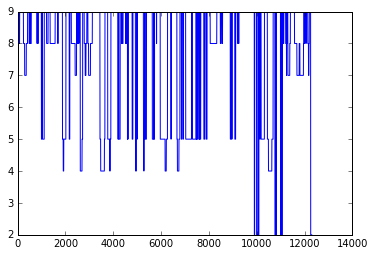

In [35]:
plt.plot([srtis_ensemble_numbers[e] for e in ensemble_trace])

In [36]:
count = 0
for i in range(len(ensemble_trace)-1):
    [this_val, next_val] = [srtis_ensemble_numbers[ensemble_trace[k]] for k in [i,i+1]]
    if this_val == 1 and next_val == 0:
        count += 1
count

0

In [37]:
hist_numbers = [srtis_ensemble_numbers[e] for e in ensemble_trace]
bins = [i-0.5 for i in range(len(srtis_ensembles)+1)]

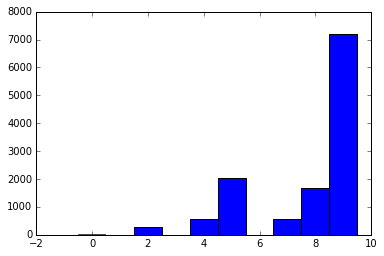

In [38]:
plt.hist(hist_numbers, bins=bins);

In [39]:
import pandas as pd
hist = paths.analysis.Histogram(bin_width=1.0, bin_range=[-0.5,9.5])
colnames = {i : srtis_numbers_ensemble[i].name for i in range(len(srtis_ensembles))}
df = pd.DataFrame(columns=[colnames[i] for i in colnames])

In [40]:
for i in range(len(hist_numbers)):
    hist.add_data_to_histogram([hist_numbers[i]])
    if i % 100 == 0:
        normalized = hist.normalized()
        local_df = pd.DataFrame([normalized.values()], index=[i], columns=[colnames[k] for k in normalized.keys()])
        df = df.append(local_df)

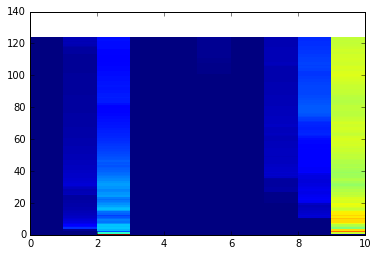

In [41]:
plt.pcolormesh(df.fillna(0.0));